In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
# from climada.hazard import TCTracks
import warnings
warnings.filterwarnings("ignore")
ccolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#### Process measurements and predicted water levels

In [2]:
stations = {'duck':8651370,
            'oregon': 8652587,
            'hatteras': 8654467,
            'beaufort':8656483,
            'wrightsville': 8658163,
            'wilmington': 8658120}

In [3]:
path = Path(r'../data/tides/NOAAtideMeasurements/')
dct = {}
for st in stations.keys():
# st = 'oregon'
    listAux = []
    files = sorted(os.listdir(path/st))
    for f in files:
        df = pd.read_csv(path/st/f, index_col = 0, parse_dates=True)
        listAux.append(df)
    dfAll = pd.concat(listAux)
    dfAll = dfAll.dropna(axis=0, subset=[' Water Level'])
    dfAll.index = pd.to_datetime(dfAll.index)
    dfAll = dfAll.sort_index()
    dct[st] = dfAll

with open(path/'measured_tides_NCstations.pkl', 'wb') as handle:
    pickle.dump(dct, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
path = Path(r'../data/tides/NOAAtidePredictions/')
dct = {}
for st in stations.keys():
# st = 'oregon'
    listAux = []
    files = sorted(os.listdir(path/st))
    for f in files:
        df = pd.read_csv(path/st/f, index_col = 0, parse_dates=True)
        listAux.append(df)
    dfAll = pd.concat(listAux)
    dfAll = dfAll.dropna(axis=0, subset=[' Prediction'])
    dfAll.index = pd.to_datetime(dfAll.index)
    dfAll = dfAll.sort_index()
    dct[st] = dfAll

with open(path/'predicted_tides_NCstations.pkl', 'wb') as handle:
    pickle.dump(dct, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Get tracks and perturbations

In [28]:
### download all tracks from 2003 to 2020
tracksAll = TCTracks.from_ibtracs_netcdf(provider='usa', basin='NA', year_range = (2003, 2020))
tracksNC = []
names = ['ISABEL', 'IRENE', 'ARTHUR', 'MATTHEW', 'FLORENCE', 'DORIAN', 'ISAIAS']
for t in tracksAll.data:
    if t.name in names:
        tracksNC.append(t)

## select corresponding storms
tracksNCdef = []
ids = []
years = [2003, 2011, 2014, 2016, 2018, 2019, 2020]
for t in tracksNC:
    name = t.name
    idx = names.index(name)
    year = years[idx]
    stormYear = pd.to_datetime(t.time[0].data).year

    if year == stormYear:
        tracksNCdef.append(t)
        ids.append(t.sid)
        print(f'{name}: {stormYear} {t.sid}')


2023-12-16 10:39:02,299 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/tomas/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


/home/tomas/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/tomas/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


ISABEL: 2003 2003249N14329
IRENE: 2011 2011233N15301
ARTHUR: 2014 2014180N32282
MATTHEW: 2016 2016273N13300
FLORENCE: 2018 2018242N13343
DORIAN: 2019 2019236N10314
ISAIAS: 2020 2020211N13306


In [29]:
dct = {}
for i, n in zip(ids, names):
    aux = TCTracks.from_ibtracs_netcdf(provider='usa', storm_id=i)
    aux.equal_timestep()
    dforg = aux.data[0].to_dataframe()
    dforg = dforg[['lon', 'lat', 'max_sustained_wind', 'central_pressure', 'radius_max_wind']]
    
    aux.calc_perturbed_trajectories(nb_synth_tracks=100)
    dfs = [dforg]
    for it, t in enumerate(aux.data):
        dummy = t.to_dataframe().loc[:, dforg.columns]
        dummy.columns = [f'{x}_pert{it:03d}' for x in dummy.columns]
        dfs.append(dummy)
    dforg2 = pd.concat(dfs, axis = 1)
    dct[n] = dforg2

2023-12-16 10:39:13,621 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/tomas/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


/home/tomas/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/tomas/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


2023-12-16 10:39:18,478 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/tomas/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2023-12-16 10:39:23,542 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/tomas/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2023-12-16 10:39:28,525 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider m

In [30]:
path = Path(r'../data/tracks/climada')
with open(path/'tracksNC_with100perturbations.pkl', 'wb') as handle:
    pickle.dump(dct, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
path = Path(r'../data/tracks/climada')
dctTracksPert = pd.read_pickle(path/'tracksNC_with100perturbations.pkl')

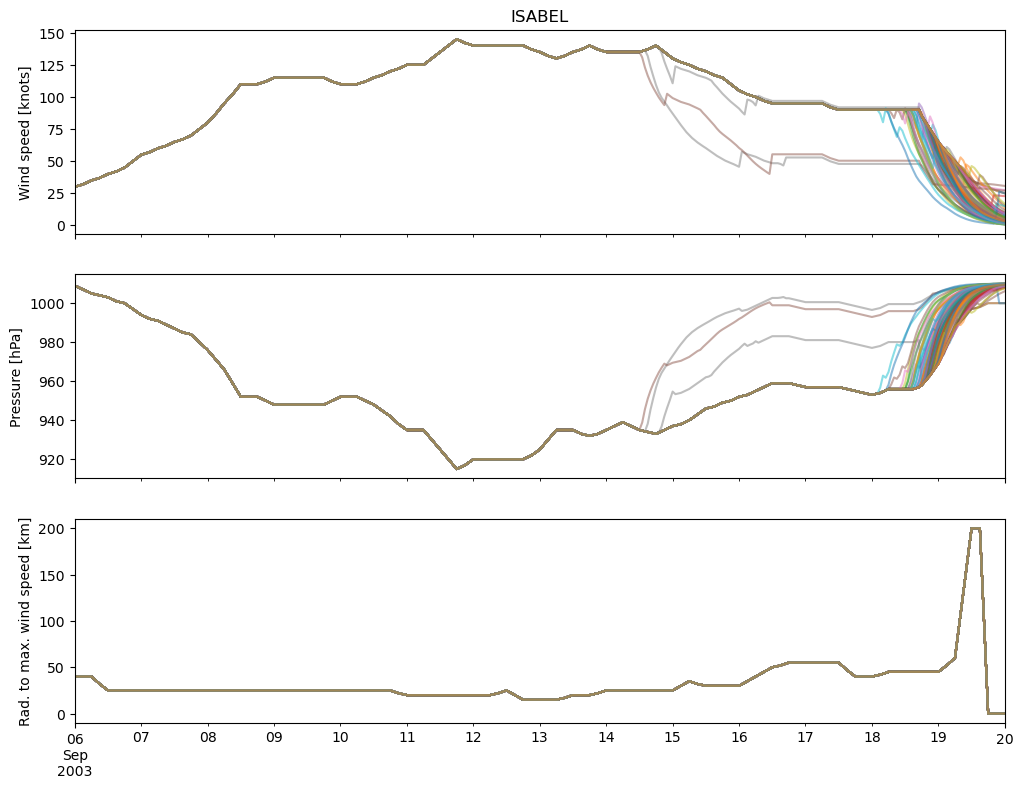

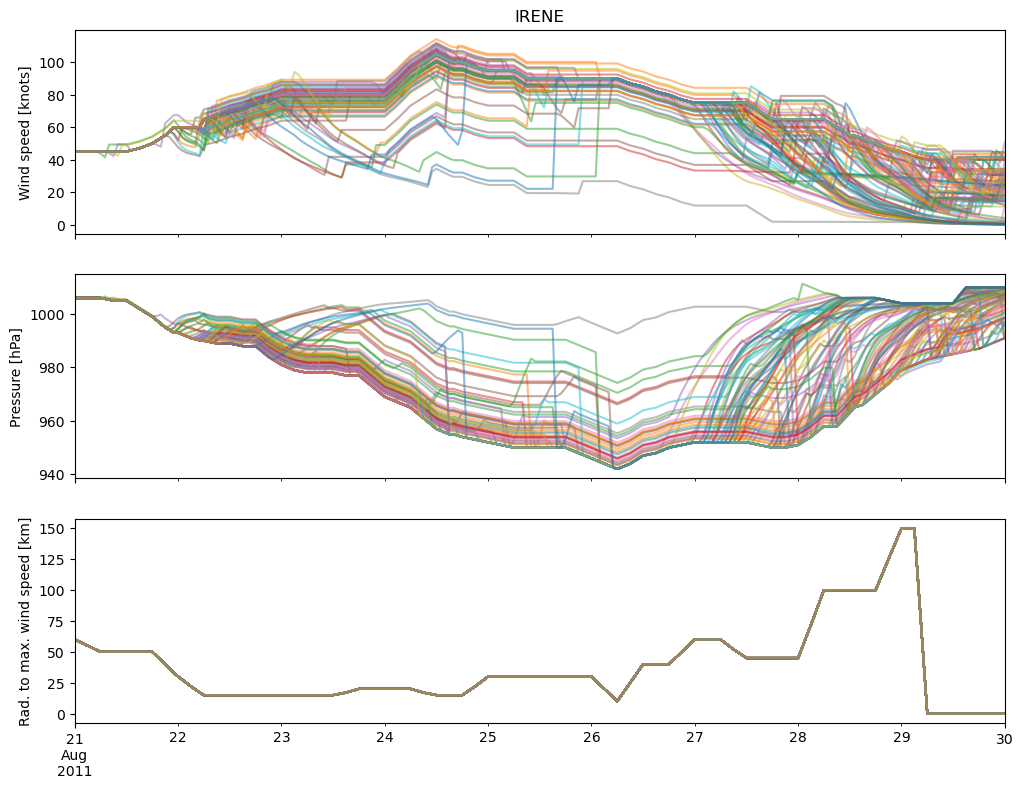

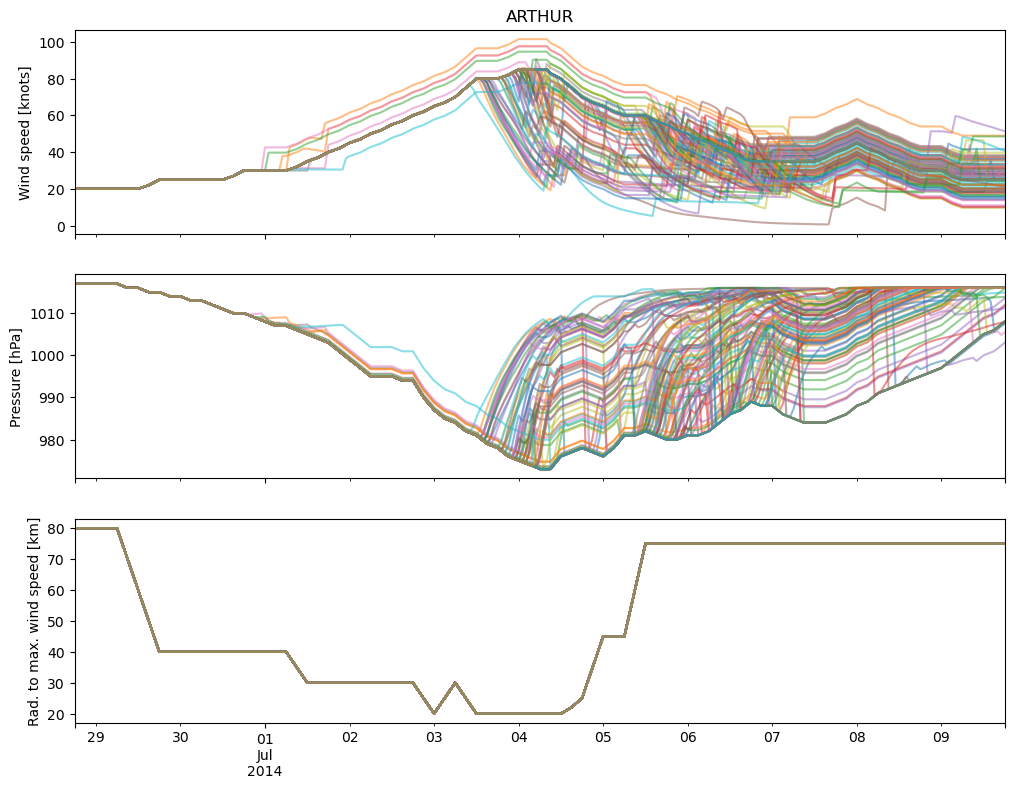

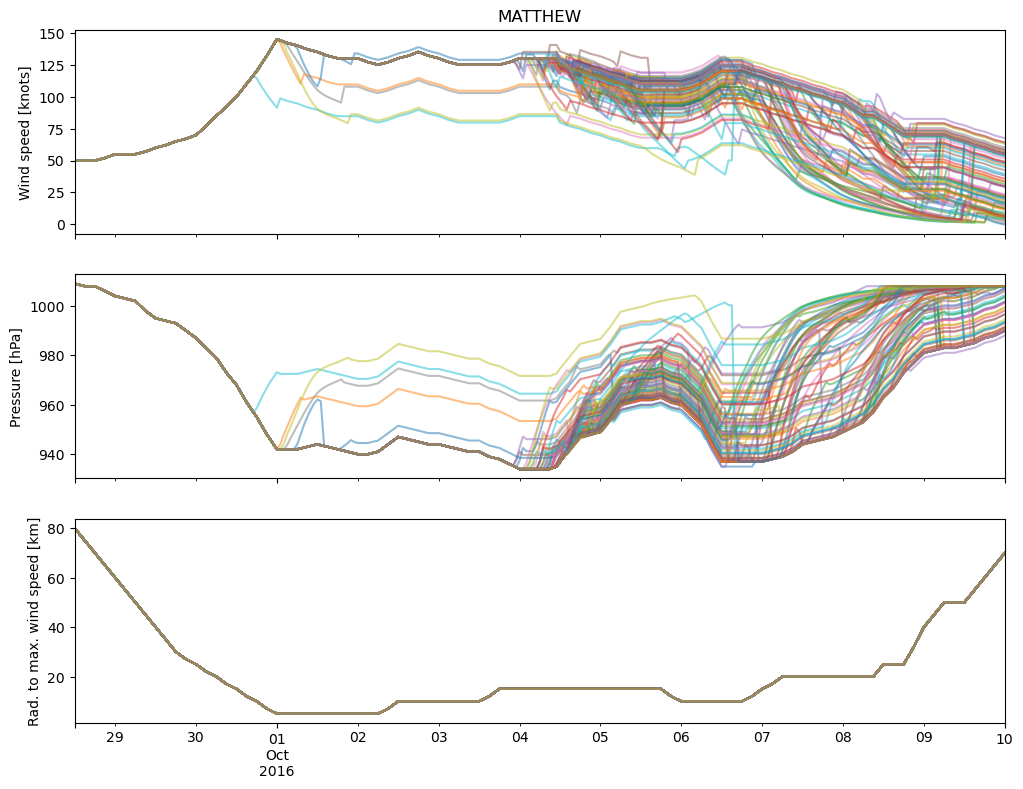

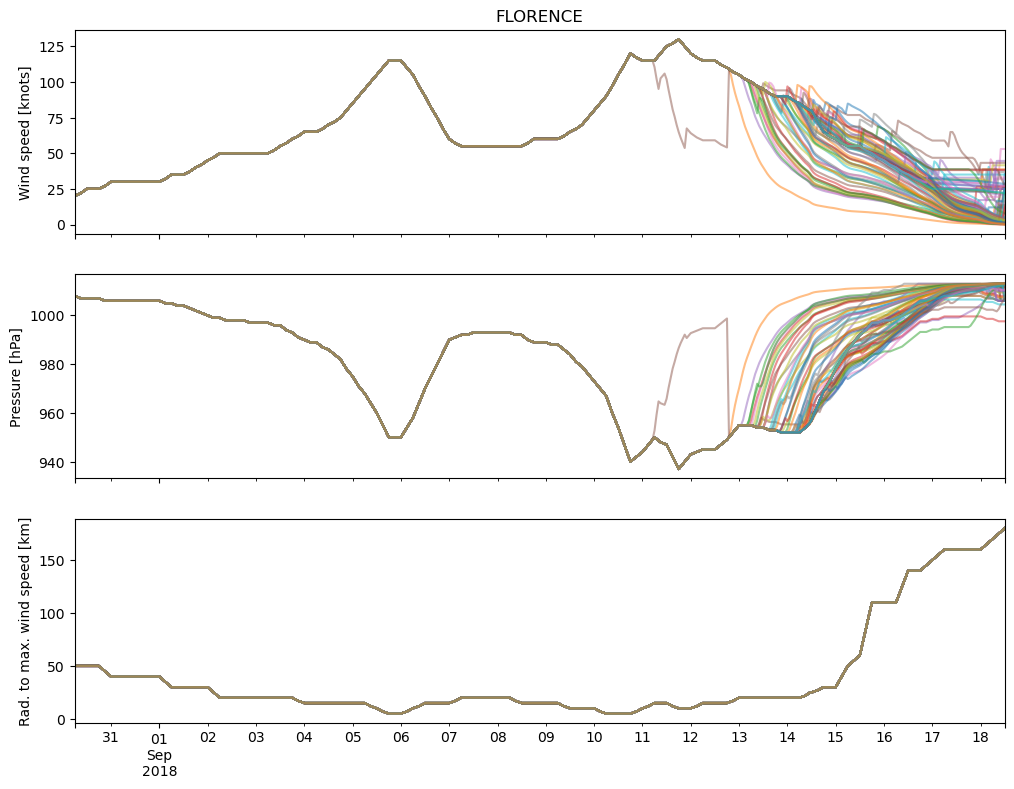

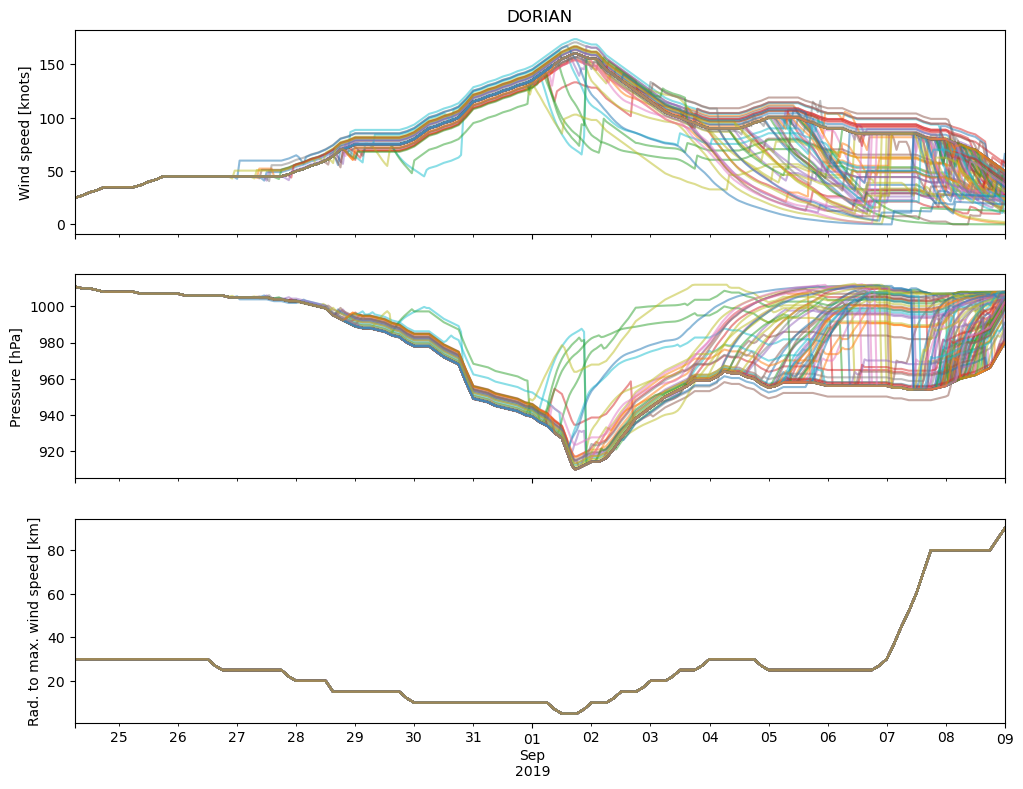

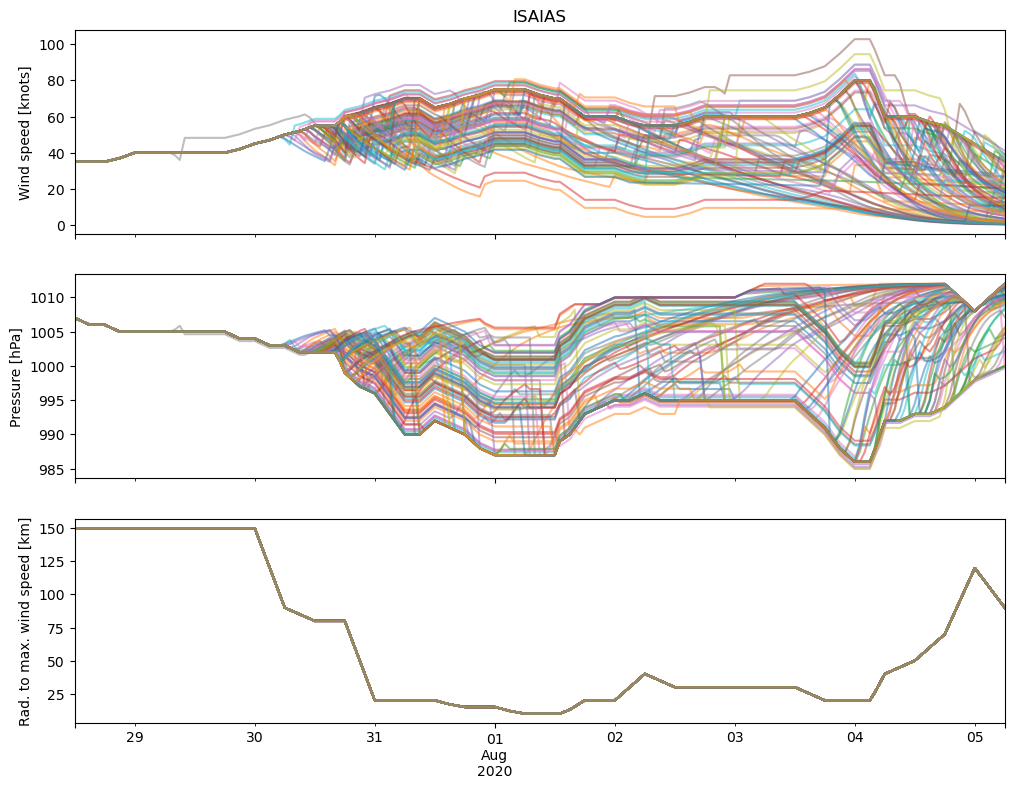

In [17]:
for k in dctTracksPert.keys():
    fig, ax = plt.subplots(figsize = (12, 9), nrows = 3, sharex = True)
    ax[0].set_title(k)
    dctTracksPert[k].loc[:, [x for x in dctTracksPert[k].columns if 'max_sustained_wind' in x]].plot(ax = ax[0], legend = False, alpha = 0.5)
    dctTracksPert[k].loc[:, [x for x in dctTracksPert[k].columns if 'central_pressure' in x]].plot(ax = ax[1], legend = False, alpha = 0.5)
    dctTracksPert[k].loc[:, [x for x in dctTracksPert[k].columns if 'radius_max_wind' in x]].plot(ax = ax[2], legend = False, alpha = 0.5)
    ax[0].set_ylabel('Wind speed [knots]')
    ax[1].set_ylabel('Pressure [hPa]')
    ax[2].set_ylabel('Rad. to max. wind speed [km]')
    ax[2].set_xlabel('')
    fig.savefig(f'../documents/thesis/{k}_track_parameters_perturbations.png', dpi = 300, bbox_inches = 'tight')

#### COmbine data

In [3]:
path = Path(r'../data/tides/NOAAtideMeasurements/')
with open(path/'measured_tides_NCstations.pkl', 'rb') as handle:
    dctMea = pickle.load(handle)

path = Path(r'../data/tides/NOAAtidePredictions/')
with open(path/'predicted_tides_NCstations.pkl', 'rb') as handle:
    dctPred = pickle.load(handle)

In [4]:
path = Path(r'../data/tracks/climada')
with open(path/'tracksNC_with100perturbations.pkl', 'rb') as handle:
    dctTracks = pickle.load(handle)

In [8]:
dctCombined = {}
dfOut = pd.DataFrame()
aux0 = []
for k in dctTracks.keys():
    print(f'{k}')
    dft = dctTracks[k]
    dfmAll = pd.DataFrame(index = dft.index, columns = dctMea.keys())
    aux1 = []
    for s in dctMea.keys():
        dfm = dctMea[s]
        dfm2 = dfm.loc[dfm.index.isin(dft.index), [' Water Level']]
        aux1.append(dfm2.max().iloc[0])
        
        dfp = dctPred[s]
        dfp2 = dfp.loc[dfp.index.isin(dft.index), [' Prediction']]
        dft[f'predTide_{s}'] = dfp2[' Prediction'].values

    aux0.append(aux1)
    dctCombined[k] = dft
dfOut = pd.DataFrame(aux0, columns = dctMea.keys(), index = dctTracks.keys())

ISABEL
IRENE
ARTHUR
MATTHEW
FLORENCE
DORIAN
ISAIAS


In [40]:
dfOut.to_csv(r'../data/probabilisticPredictions/measuredPeakWaterLevel_stormsNC.csv')

In [18]:
for k in dctCombined.keys():
    print(f'{k}')
    print(dctCombined[k].iloc[:, -6:].isna().sum())
    print('\n')

ISABEL
predTide_duck            0
predTide_oregon          0
predTide_hatteras        0
predTide_beaufort        0
predTide_wrightsville    0
predTide_wilmington      0
dtype: int64


IRENE
predTide_duck            0
predTide_oregon          0
predTide_hatteras        0
predTide_beaufort        0
predTide_wrightsville    0
predTide_wilmington      0
dtype: int64


ARTHUR
predTide_duck            0
predTide_oregon          0
predTide_hatteras        0
predTide_beaufort        0
predTide_wrightsville    0
predTide_wilmington      0
dtype: int64


MATTHEW
predTide_duck            0
predTide_oregon          0
predTide_hatteras        0
predTide_beaufort        0
predTide_wrightsville    0
predTide_wilmington      0
dtype: int64


FLORENCE
predTide_duck            0
predTide_oregon          0
predTide_hatteras        0
predTide_beaufort        0
predTide_wrightsville    0
predTide_wilmington      0
dtype: int64


DORIAN
predTide_duck            0
predTide_oregon          0
predTide_hatteras

In [20]:
dfOut

,duck,oregon,hatteras,beaufort,wrightsville,wilmington
ISABEL,1.828,1.490,NaN,1.199,NaN,0.969
IRENE,1.053,2.156,1.163,1.371,1.459,0.841
ARTHUR,0.795,1.218,0.609,0.979,1.016,0.833
MATTHEW,1.133,0.906,1.846,1.199,1.464,1.755
FLORENCE,1.299,0.697,0.637,1.681,1.911,1.764
DORIAN,1.529,1.126,1.600,1.069,1.334,1.166
ISAIAS,0.832,0.912,0.356,0.978,1.438,2.009
